Dataset shape after removing outliers: (24420, 29)

Best Performing Pair (La Liga -> Serie A)
Training on league_La_liga, Testing on league_Serie_A
Accuracy: 0.4763
              precision    recall  f1-score   support

          -1       0.51      0.58      0.54      1705
           0       0.32      0.17      0.22      1140
           1       0.49      0.58      0.53      1682

    accuracy                           0.48      4527
   macro avg       0.44      0.44      0.43      4527
weighted avg       0.46      0.48      0.46      4527

[[990 201 514]
 [448 192 500]
 [505 203 974]]


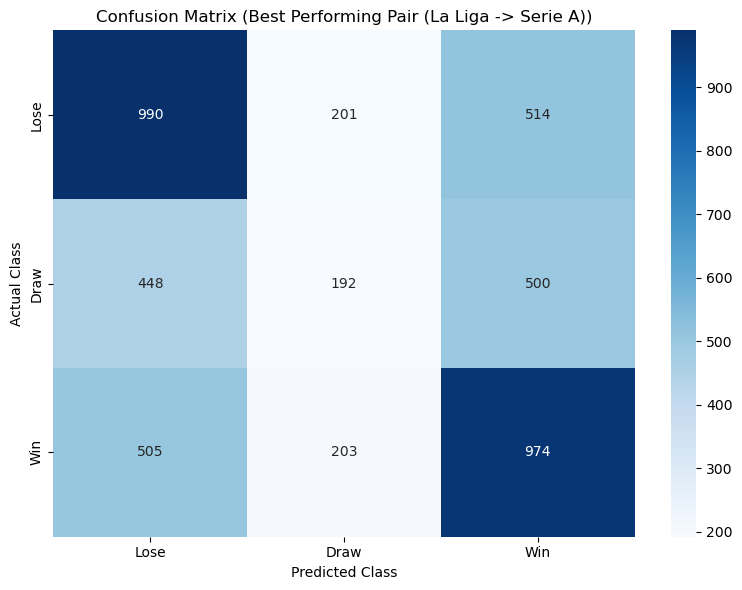


Worst Performing Pair (EPL -> RFPL)
Training on league_EPL, Testing on league_RFPL
Accuracy: 0.4053
              precision    recall  f1-score   support

          -1       0.47      0.44      0.45      1045
           0       0.29      0.35      0.32       790
           1       0.46      0.42      0.44      1027

    accuracy                           0.41      2862
   macro avg       0.41      0.40      0.40      2862
weighted avg       0.42      0.41      0.41      2862

[[456 342 247]
 [256 276 258]
 [264 335 428]]


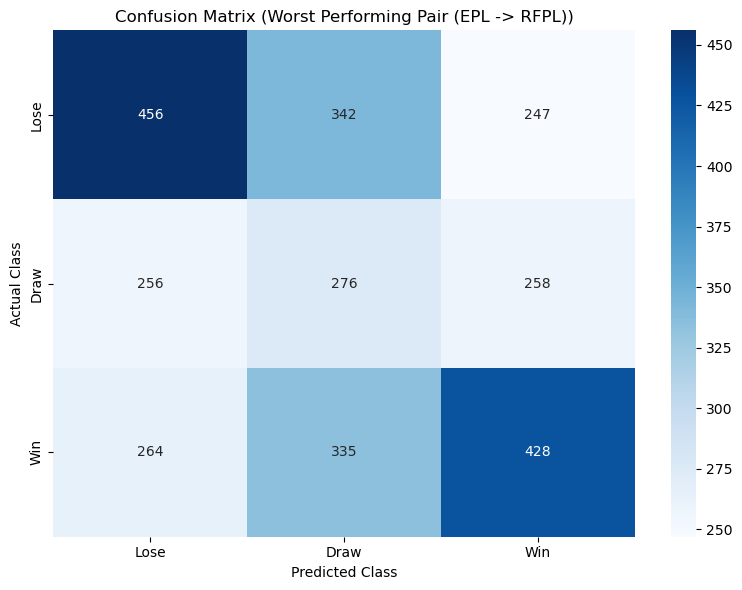

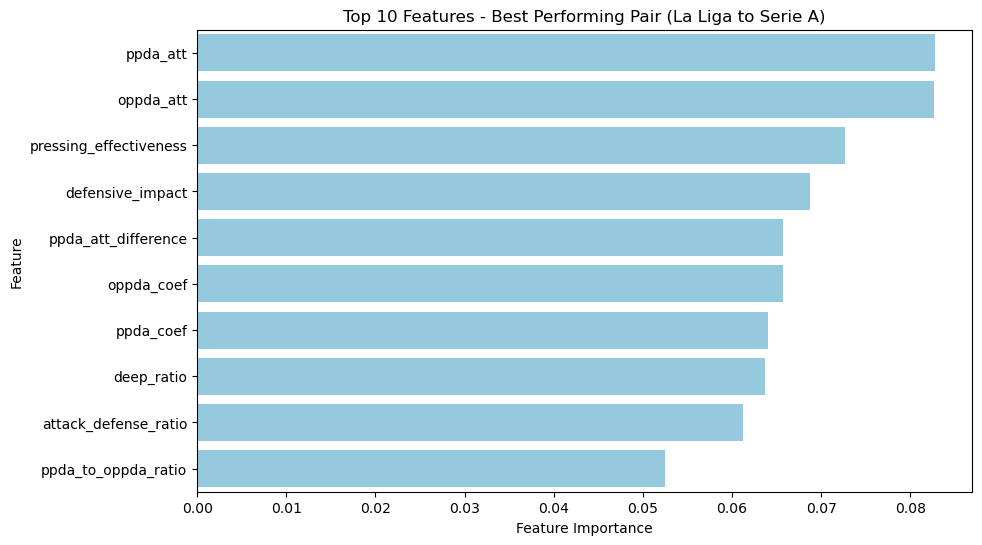

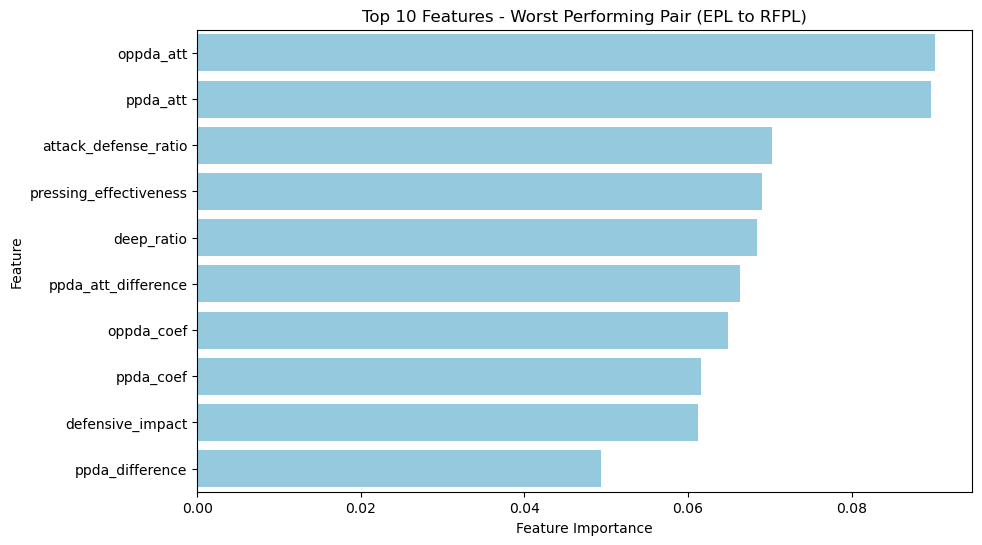

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
file_path = "understat_per_game.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Step 2: Handle outliers in the target variable ('scored') using the IQR method
Q1 = data['scored'].quantile(0.25)
Q3 = data['scored'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[(data['scored'] >= lower_bound) & (data['scored'] <= upper_bound)]
print(f"Dataset shape after removing outliers: {data.shape}")

# Encode the target variable for multiclass classification
result_mapping = {'w': 1, 'd': 0, 'l': -1}  # Win = 1, Draw = 0, Loss = -1
data['result'] = data['result'].map(result_mapping)
data = data.dropna()

# Step 2: Feature Engineering
data['deep_ratio'] = data['deep'] / (data['deep_allowed'] + 1)  # Avoid division by zero
data['ppda_ratio'] = data['ppda_coef'] / (data['oppda_coef'] + 1)
data['ppda_difference'] = data['ppda_coef'] - data['oppda_coef']
data['ppda_att_difference'] = data['ppda_att'] - data['oppda_att']
data['pressing_effectiveness'] = data['ppda_coef'] * data['deep']
data['defensive_impact'] = data['ppda_def'] * data['deep_allowed']
data['attack_defense_ratio'] = data['deep'] / (data['deep_allowed'] + 1)
data['pressing_dominance'] = data['ppda_coef'] - data['oppda_coef']
data['ppda_to_oppda_ratio'] = data['ppda_coef'] / (data['oppda_coef'] + 1)

# Combine tactical features and engineered features
tactical_features = [
    'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 
    'ppda_att', 'ppda_def', 'oppda_att', 'oppda_def',
    'deep_ratio', 'ppda_ratio', 'ppda_difference', 'ppda_att_difference',
    'pressing_effectiveness', 'defensive_impact', 'attack_defense_ratio',
    'pressing_dominance', 'ppda_to_oppda_ratio'
]

# Apply one-hot encoding to categorical columns ('h_a', 'league')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

# Define target and features
X = data[tactical_features]
y = data['result']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to evaluate model for a given league pair
def evaluate_league_pair(train_league, test_league, title):
    train_indices = data[train_league] == 1
    test_indices = data[test_league] == 1
    
    X_train, y_train = X_scaled[train_indices], y[train_indices]
    X_test, y_test = X_scaled[test_indices], y[test_indices]
    
    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{title}")
    print(f"Training on {train_league}, Testing on {test_league}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    # Calculate feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    classes = ['Lose', 'Draw', 'Win']  # Replace with actual class labels if needed
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(f'Confusion Matrix ({title})')
    plt.tight_layout()
    plt.show()
    
    return accuracy, importance

# Step 3: Evaluate the best and worst-performing pairs
# Best Performing Pair: La Liga -> Serie A
best_accuracy, best_importance = evaluate_league_pair(
    train_league='league_La_liga', 
    test_league='league_Serie_A',
    title="Best Performing Pair (La Liga -> Serie A)"
)

# Worst Performing Pair: EPL -> RFPL
worst_accuracy, worst_importance = evaluate_league_pair(
    train_league='league_EPL', 
    test_league='league_RFPL',
    title="Worst Performing Pair (EPL -> RFPL)"
)

# Step 4: Visualize feature importance
def plot_feature_importance(importance, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance.head(10), x='Importance', y='Feature', color='skyblue')
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.show()

# Plot feature importance for each pair
plot_feature_importance(best_importance, "Top 10 Features - Best Performing Pair (La Liga to Serie A)")
plot_feature_importance(worst_importance, "Top 10 Features - Worst Performing Pair (EPL to RFPL)")

# Save feature importance results
best_importance.to_csv('best_pair_importance.csv', index=False)
worst_importance.to_csv('worst_pair_importance.csv', index=False)
 

T-test results for La Liga vs Serie A:
deep: T-statistic = -5.1012, P-value = 0.0000
deep_allowed: T-statistic = -4.2943, P-value = 0.0000
ppda_att: T-statistic = -11.8359, P-value = 0.0000
oppda_att: T-statistic = -12.2308, P-value = 0.0000


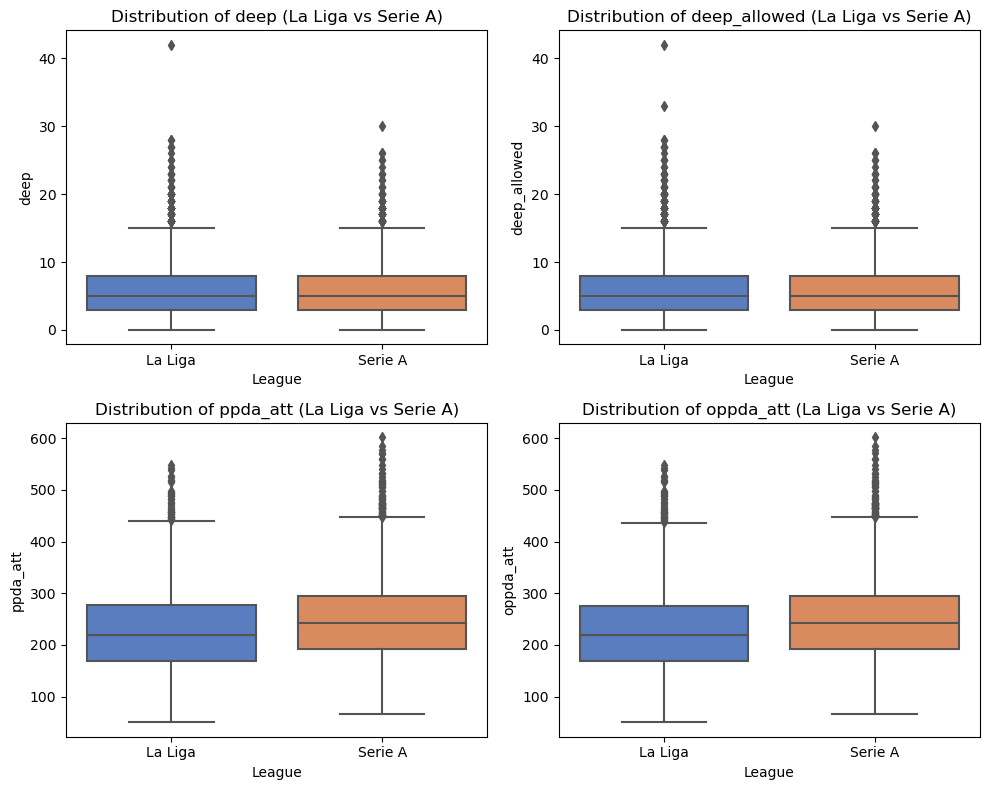

T-test results for EPL vs RFPL:
deep: T-statistic = 5.7703, P-value = 0.0000
deep_allowed: T-statistic = 5.5383, P-value = 0.0000
ppda_att: T-statistic = 13.7331, P-value = 0.0000
oppda_att: T-statistic = 13.7477, P-value = 0.0000


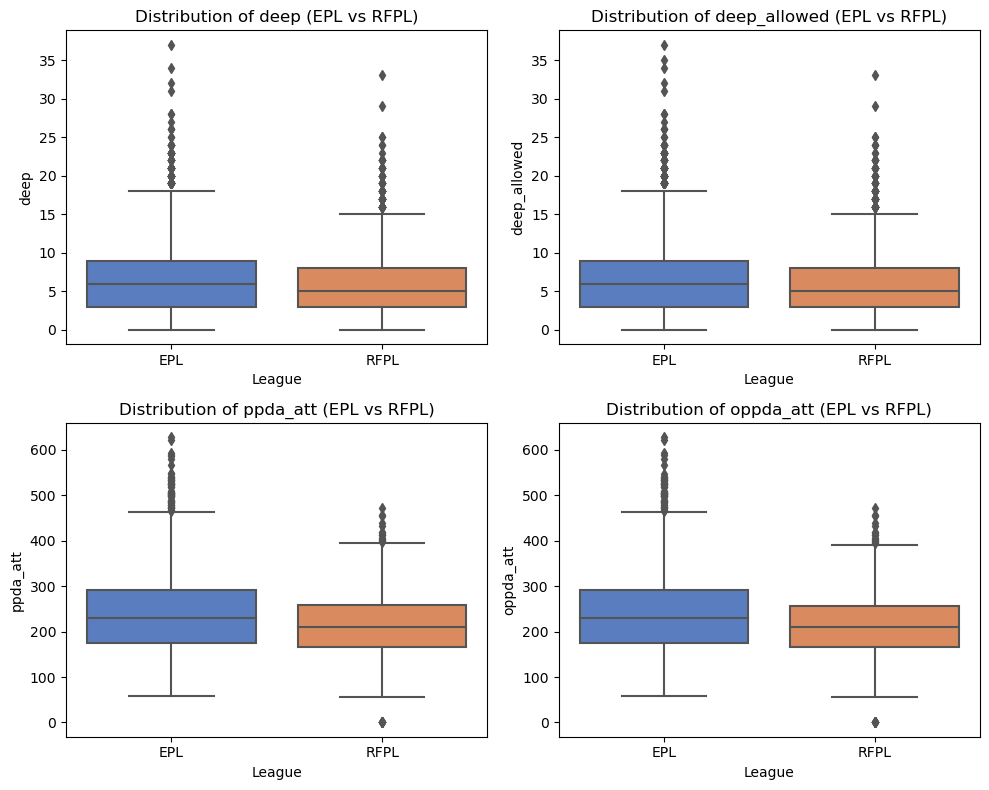


T-test Summary for La Liga vs Serie A:
         Metric  T-statistic       P-value
0          deep    -5.101225  3.443271e-07
1  deep_allowed    -4.294279  1.771002e-05
2      ppda_att   -11.835883  4.389251e-32
3     oppda_att   -12.230831  3.954315e-34

T-test Summary for EPL vs RFPL:
         Metric  T-statistic       P-value
0          deep     5.770269  8.276471e-09
1  deep_allowed     5.538296  3.173547e-08
2      ppda_att    13.733138  2.226094e-42
3     oppda_att    13.747670  1.833710e-42


In [13]:
# Define the key metrics for comparison
metrics = ['deep', 'deep_allowed', 'ppda_att', 'oppda_att']

# Function to extract league-specific data
def extract_league_data(data, league_column):
    return data[data[league_column] == 1]

# Step 1: Extract data for each league pair
la_liga_data = extract_league_data(data, 'league_La_liga')
serie_a_data = extract_league_data(data, 'league_Serie_A')
epl_data = extract_league_data(data, 'league_EPL')
rfpl_data = extract_league_data(data, 'league_RFPL')

# Function to perform t-tests and visualize boxplots
def visualize_and_compare(data1, data2, league1_name, league2_name, metrics):
    print(f"T-test results for {league1_name} vs {league2_name}:")
    t_test_results = []
    for metric in metrics:
        stat, p_value = ttest_ind(data1[metric], data2[metric], equal_var=False)
        t_test_results.append({'Metric': metric, 'T-statistic': stat, 'P-value': p_value})
        print(f"{metric}: T-statistic = {stat:.4f}, P-value = {p_value:.4f}")

    # Create boxplots for the metrics
    plt.figure(figsize=(10, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)  # Adjusted for 4 metrics in a 2x2 grid
        sns.boxplot(data=pd.concat([
            data1[[metric]].assign(League=league1_name),
            data2[[metric]].assign(League=league2_name)
        ]), x='League', y=metric, palette="muted")
        plt.title(f"Distribution of {metric} ({league1_name} vs {league2_name})")
        plt.xlabel('League')
        plt.ylabel(metric)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(t_test_results)

# Step 2: Compare La Liga vs Serie A
t_test_results_la_liga_serie_a = visualize_and_compare(
    la_liga_data, serie_a_data, "La Liga", "Serie A", metrics
)

# Step 3: Compare EPL vs RFPL
t_test_results_epl_rfpl = visualize_and_compare(
    epl_data, rfpl_data, "EPL", "RFPL", metrics
)

# Display T-test results
print("\nT-test Summary for La Liga vs Serie A:")
print(t_test_results_la_liga_serie_a)

print("\nT-test Summary for EPL vs RFPL:")
print(t_test_results_epl_rfpl)




<Figure size 1200x800 with 0 Axes>

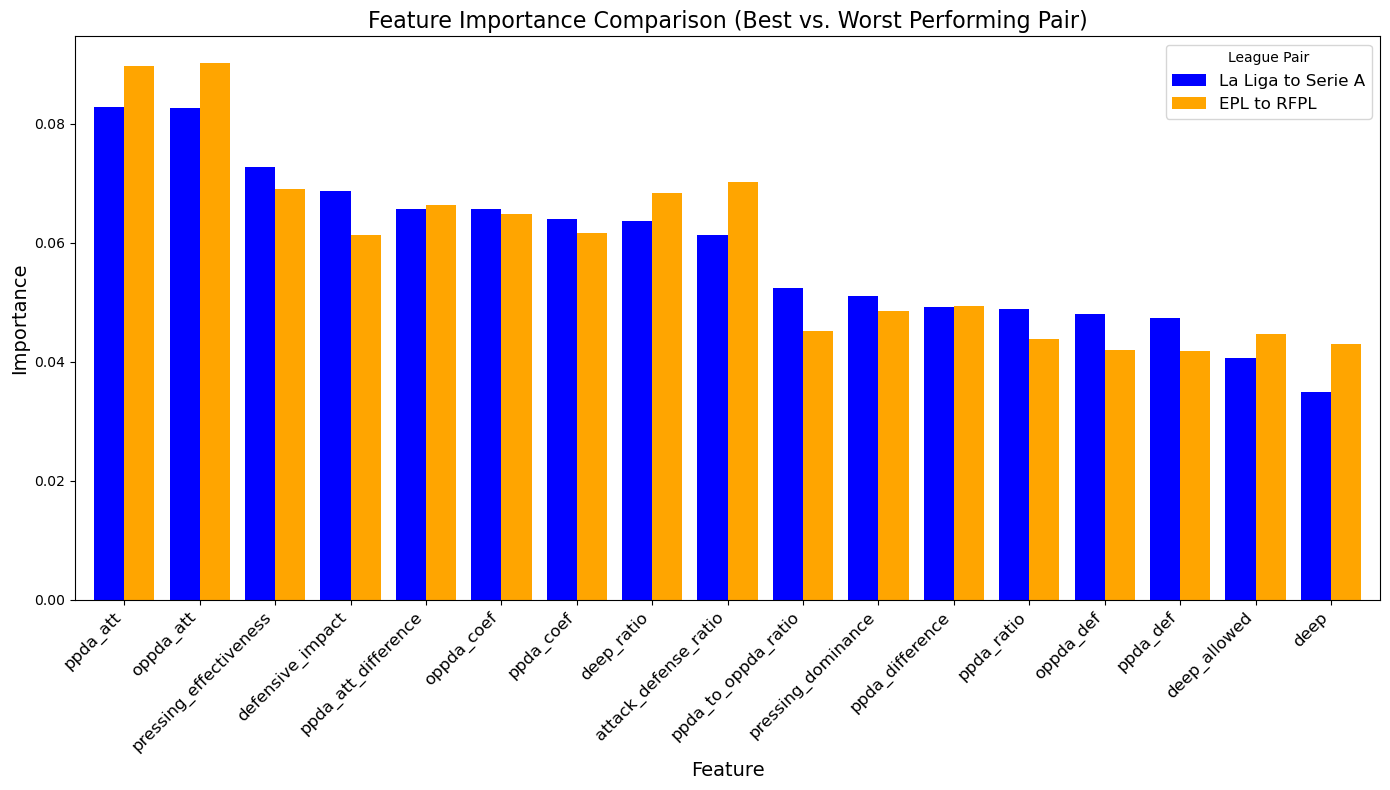

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the feature importance data for the two league pairs
importance_la_liga_serie_a = best_importance.rename(columns={'Importance': 'La Liga to Serie A'})
importance_epl_rfpl = worst_importance.rename(columns={'Importance': 'EPL to RFPL'})

# Merge the two dataframes on the feature name
importance_comparison = pd.merge(
    importance_la_liga_serie_a[['Feature', 'La Liga to Serie A']],
    importance_epl_rfpl[['Feature', 'EPL to RFPL']],
    on='Feature'
)

# Plot the feature importance comparison
plt.figure(figsize=(12, 8))
importance_comparison.set_index('Feature').plot(kind='bar', figsize=(14, 8), width=0.8, color=['blue', 'orange'])
plt.title("Feature Importance Comparison (Best vs. Worst Performing Pair)", fontsize=16)
plt.ylabel("Importance", fontsize=14)
plt.xlabel("Feature", fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.legend(title="League Pair", fontsize=12)
plt.tight_layout()
plt.show()


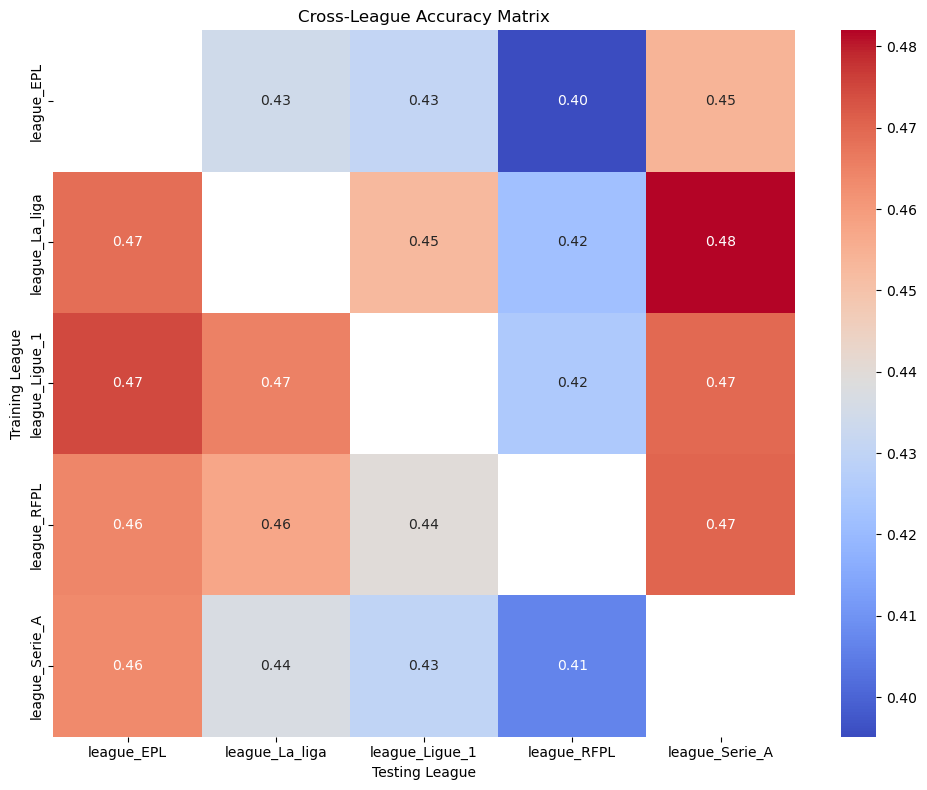

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
file_path = "understat_per_game.csv"  # Replace with your dataset path
data = pd.read_csv(file_path)

# Encode the target variable for multiclass classification
result_mapping = {'w': 1, 'd': 0, 'l': -1}  # Win = 1, Draw = 0, Loss = -1
data['result'] = data['result'].map(result_mapping)
data = data.dropna()

# Step 2: Feature Engineering
data['deep_ratio'] = data['deep'] / (data['deep_allowed'] + 1)  # Avoid division by zero
data['ppda_ratio'] = data['ppda_coef'] / (data['oppda_coef'] + 1)
data['ppda_difference'] = data['ppda_coef'] - data['oppda_coef']
data['ppda_att_difference'] = data['ppda_att'] - data['oppda_att']
data['pressing_effectiveness'] = data['ppda_coef'] * data['deep']
data['defensive_impact'] = data['ppda_def'] * data['deep_allowed']
data['attack_defense_ratio'] = data['deep'] / (data['deep_allowed'] + 1)
data['pressing_dominance'] = data['ppda_coef'] - data['oppda_coef']
data['ppda_to_oppda_ratio'] = data['ppda_coef'] / (data['oppda_coef'] + 1)

# Combine tactical features and engineered features
tactical_features = [
    'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 
    'ppda_att', 'ppda_def', 'oppda_att', 'oppda_def',
    'deep_ratio', 'ppda_ratio', 'ppda_difference', 'ppda_att_difference',
    'pressing_effectiveness', 'defensive_impact', 'attack_defense_ratio',
    'pressing_dominance', 'ppda_to_oppda_ratio'
]

# Apply one-hot encoding to categorical columns ('h_a', 'league')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

# Define target and features
X = data[tactical_features]
y = data['result']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Prepare League Pairs for Training and Testing
league_columns = [col for col in data.columns if col.startswith('league_')]
results = []

for train_league in league_columns:
    for test_league in league_columns:
        if train_league != test_league:
            # Create training and testing splits
            train_indices = data[train_league] == 1
            test_indices = data[test_league] == 1
            
            X_train, y_train = X_scaled[train_indices], y[train_indices]
            X_test, y_test = X_scaled[test_indices], y[test_indices]
            
            # Train Random Forest model
            rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
            rf_model.fit(X_train, y_train)
            
            # Evaluate the model
            y_pred = rf_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results.append({'train_league': train_league, 'test_league': test_league, 'accuracy': accuracy})

# Step 4: Create a Cross-League Accuracy Matrix
results_df = pd.DataFrame(results)
accuracy_matrix = results_df.pivot(index='train_league', columns='test_league', values='accuracy')

# Step 5: Visualize the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cross-League Accuracy Matrix')
plt.xlabel('Testing League')
plt.ylabel('Training League')
plt.tight_layout()
plt.show()


In [16]:
# Example: Analyze misclassifications
misclassified_indices = np.where(y_test != y_pred)[0]

# Subset the test data to misclassified cases
misclassified_data = X_test[misclassified_indices]
misclassified_actual = y_test.iloc[misclassified_indices]
misclassified_pred = y_pred[misclassified_indices]

# Add actual and predicted labels for further analysis
misclassified_df = pd.DataFrame(misclassified_data, columns=X.columns)
misclassified_df['Actual'] = misclassified_actual.values
misclassified_df['Predicted'] = misclassified_pred

# Analyze misclassification patterns
print(misclassified_df.groupby(['Actual', 'Predicted']).size())


Actual  Predicted
-1       0           383
         1           243
 0      -1           236
         1           229
 1      -1           234
         0           384
dtype: int64


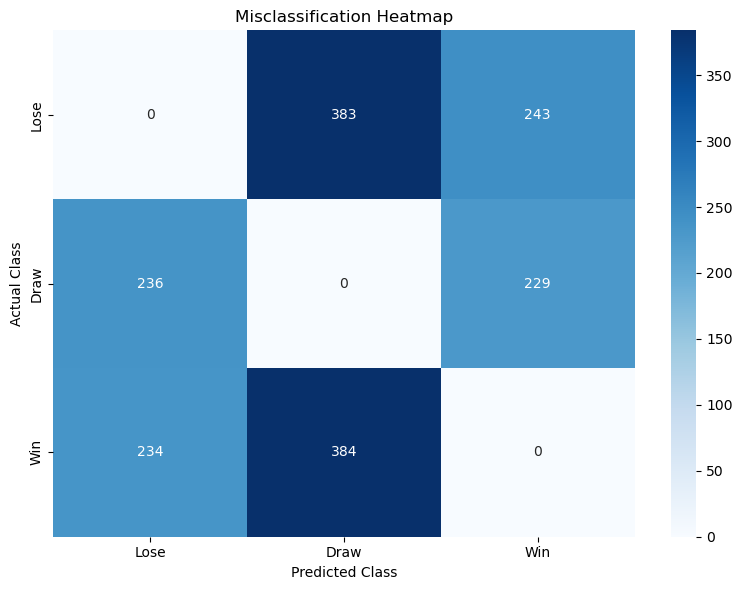

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table for visualization
misclassification_matrix = misclassified_df.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    misclassification_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Lose', 'Draw', 'Win'], 
    yticklabels=['Lose', 'Draw', 'Win']
)
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()


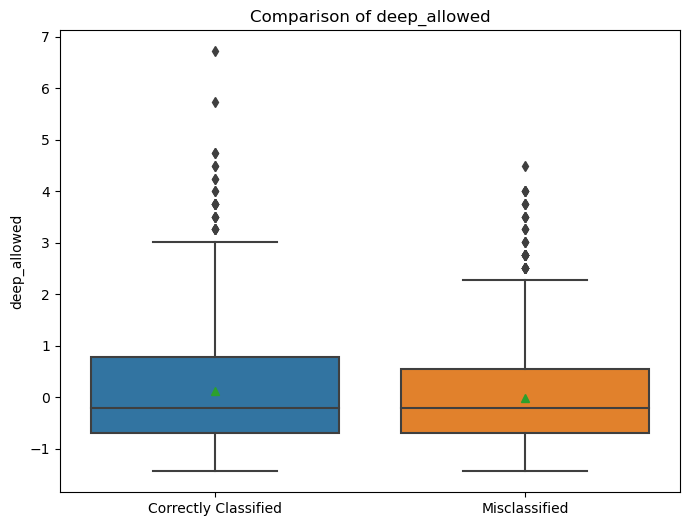

In [17]:
# Compare a specific feature (e.g., 'deep_allowed') for correctly vs. incorrectly classified cases
correct_indices = np.where(y_test == y_pred)[0]

# Subset correct and incorrect cases
correct_data = X_test[correct_indices]
incorrect_data = misclassified_data

# Boxplot comparison for a specific feature
feature_to_compare = 'deep_allowed'
plt.figure(figsize=(8, 6))
sns.boxplot(data=[
    correct_data[:, X.columns.get_loc(feature_to_compare)],
    incorrect_data[:, X.columns.get_loc(feature_to_compare)]
], showmeans=True)
plt.xticks([0, 1], ['Correctly Classified', 'Misclassified'])
plt.title(f'Comparison of {feature_to_compare}')
plt.ylabel(feature_to_compare)
plt.show()


In [18]:
# Use feature importance from the Random Forest model
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Correlate top features with misclassified cases
top_features = importance_df['Feature'].head(5)
misclassified_features = misclassified_df[top_features]

# Compare mean or variance of top features in misclassified cases
print(misclassified_features.describe())


         oppda_att     ppda_att   oppda_coef  pressing_effectiveness  \
count  1709.000000  1709.000000  1709.000000             1709.000000   
mean     -0.363423    -0.373210    -0.083927               -0.061855   
std       0.744343     0.739494     0.828722                0.906135   
min      -2.852638    -2.852638    -1.769199               -1.328535   
25%      -0.900182    -0.923992    -0.659432               -0.679973   
50%      -0.400162    -0.400162    -0.264731               -0.249021   
75%       0.147478     0.135573     0.291332                0.325379   
max       2.099934     2.099934     5.459785                5.576833   

       ppda_att_difference  
count          1709.000000  
mean             -0.005990  
std               0.761628  
min              -2.069271  
25%              -0.553749  
50%              -0.007286  
75%               0.539176  
max               1.996410  


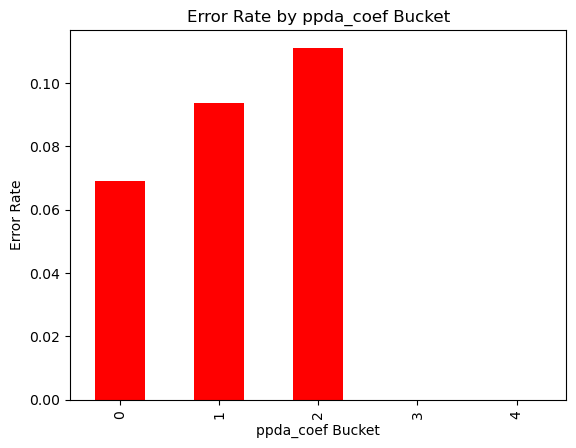

In [20]:
# Step 1: Create the ppda_coef_bucket column in the original data
data['ppda_coef_bucket'] = pd.cut(data['ppda_coef'], bins=5, labels=False)

# Step 2: Merge the bucket information into the misclassified_df
misclassified_df['ppda_coef_bucket'] = data.iloc[misclassified_indices]['ppda_coef_bucket'].values

# Step 3: Calculate the error rates for each bucket
error_counts = misclassified_df['ppda_coef_bucket'].value_counts()
total_counts = data['ppda_coef_bucket'].value_counts()
error_rates = (error_counts / total_counts).sort_index()

# Step 4: Plot the error rates
error_rates.plot(kind='bar', color='red')
plt.title('Error Rate by ppda_coef Bucket')
plt.xlabel('ppda_coef Bucket')
plt.ylabel('Error Rate')
plt.show()
